In [1]:
import pdb
import csv
from math import log10, floor

import numpy as np
import scipy
import scipy.optimize as op
import scipy.special as spec
from scipy import stats
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
matplotlib.rcParams.update({'font.size': 14})
import seaborn as sns
import corner

import astropy
from astropy import stats as astrostats
from astropy.timeseries import LombScargle

import emcee
import radvel

import occur
from occur import Completeness, Hierarchy

%matplotlib inline

In [2]:
def lngrid(min_a, max_a, min_M, max_M, resa, resm):
    lna1 = np.log(min_a)
    lna2 = np.log(max_a)
    lnM1 = np.log(min_M)
    lnM2 = np.log(max_M)
    
    dlna = (lna2 - lna1)/resa
    dlnM = (lnM2 - lnM1)/resm

    bins = []
    for i in np.arange(int(resa)):
        for j in np.arange(int(resm)):
            bins.append([[lna1 + i*dlna, lna1 + (i+1)*dlna], 
                         [lnM1 + j*dlnM, lnM1 + (j+1)*dlnM]])
            
    return np.array(bins)

# Assuming a polished list of known planets and candidates in the legacy sample, explore and visualize properties such as mass, host star metallicity, etc.

In [3]:
data = pd.read_csv('../CLSI/legacy_tables/system_props.csv')

In [4]:
specmatch = pd.read_csv('/Users/lee/Academics/Astronomy/Planets/CLSI/legacy_tables/legacy_specmatch_medians.csv')
smsyn = specmatch.query('teff_emp > 4700')
smemp = specmatch.query('teff_emp <= 4700')
fe_select = specmatch['fe_c'].to_list()

In [5]:
objects = pd.read_csv('../CLSI/legacy_tables/planet_list.csv')
trends = pd.read_csv('../CLSI/legacy_tables/trend_list.csv')

## Sort the planets into real, new candidates, known.

In [6]:
objects_real = objects.query('status == "K" or status == "C" or status == "S"').reset_index(drop=True)
objects_good = objects_real.query('mass != "nan"').reset_index(drop=True)
objects_s    = objects_good.query('status == "S" or status == "SS"').reset_index(drop=True)
planets      = objects_good.query('status == "K" or status == "C" or status == "J"').reset_index(drop=True)
planets_old  = planets.query('status == "K"').reset_index(drop=True)
planets_new  = planets.query('status == "C" or status == "J"').reset_index(drop=True)

In [7]:
names = np.unique(planets.query('mass >= 0.1 and hostname != "143761"').hostname)
multistats = []
singlenames = []
multinames = []
giantnames = []
singlecircnames = []
singleeccnames  = []
hotnames  = []
coldnames = []

bad_names = ['114762', '143761', '28185', '42581', \
              '8375', '72659', '167215']

for name in names:
    sample = planets.query('mass >= 0.1 and hostname == @name')
    ngiants = len(sample)
    if ngiants >= 1:
        giantnames.append(name)
    multistats.append(ngiants)
    
    if ngiants == 1:
        singlenames.append(name)
        if np.array(planets.query('mass >= 0.1 and hostname == @name').e)[0] < 0.2:
            singlecircnames.append(name)
        else:
            singleeccnames.append(name)
    elif ngiants > 1:
        multinames.append(name)
    else:
        pass
    
    for axis in list(sample.axis):
        if axis <= 0.1:
            hotnames.append(name)
        else:coldnames.append(name)
            
hotnames = np.unique(hotnames)
coldnames = np.unique(coldnames)

In [8]:
print(len(singlecircnames), len(singleeccnames))

38 26


In [9]:
2*multistats.count(2) + 3*multistats.count(3) + 4*multistats.count(4) + 5*multistats.count(5)

69

In [10]:
multistats.count(2)

26

In [11]:
multistats.count(3) + multistats.count(4) 

5

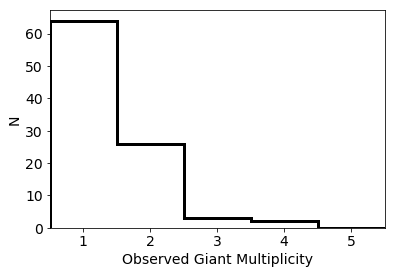

In [12]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

ax.hist(multistats, color='black', histtype='step', lw=3, range=(0.5, 5.5), bins=5)
ax.set_xlim([0.5, 5.5])
ax.set_xlabel('Observed Giant Multiplicity')
ax.set_ylabel('N')
fig.savefig('plots/observed_giant_multiplicity.pdf', bbox_inches='tight')

## Make log-axis ratio for two-planet systems.

In [12]:
logratios = []
for index, name in enumerate(giantnames):
    if multistats[index] == 2:
        pair = planets.query('mass >= 0.1 and hostname == @name')
        logratios.append(np.log10(np.amax(pair.axis)) - np.log10(np.amin(pair.axis)))

In [13]:
len(logratios)

26

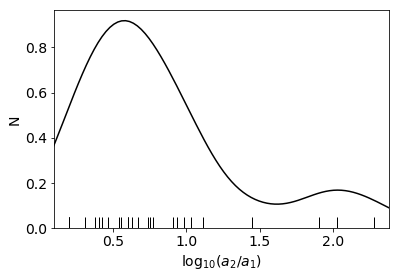

In [14]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

ax.set_xlim([np.amin(logratios) - 0.1, np.amax(logratios) + 0.1])
ax.set_xlabel(r'log$_{10}$($a_2/a_1$)')
ax.set_ylabel(r'N')
sns.distplot(logratios, rug=True, hist=False, kde=True, ax=ax, color='black')
fig.savefig('plots/log_axis_ratios.pdf', bbox_inches='tight')

## Look at total planetary mass, rather than multiplicity.

In [15]:
pnames = np.unique(planets.hostname) #.query('mass >= 0.1')
metals = [np.array(specmatch.query('name == @pname').fe_c)[0] for pname in pnames]
masses = [np.array(specmatch.query('name == @pname').mass_c)[0] for pname in pnames]
tmass  = [np.sum(planets.query('hostname == @pname').mass) for pname in pnames]

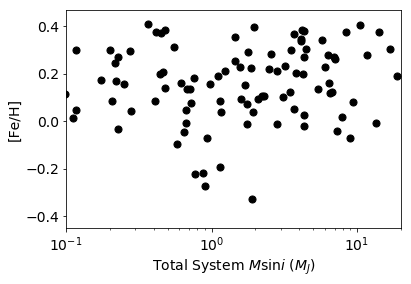

In [16]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.scatter(tmass, metals, c='black', s=50)
ax.set_xlabel(r'Total System $M$sin$i$ ($M_J$)')
ax.set_ylabel('[Fe/H]')
ax.set_xlim([0.1, 20])
#ax.set_ylim([-0.15, 0.5])
ax.set_xscale('log')

fig.savefig('plots/metals_vs_totmsini.pdf', bbox_inches='tight')

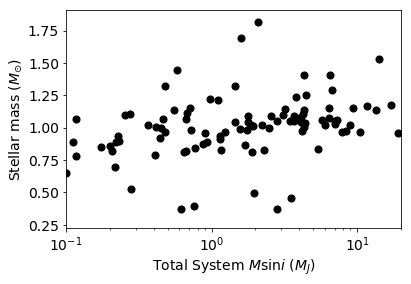

In [17]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.scatter(tmass, masses, c='black', s=50)
ax.set_xlabel(r'Total System $M$sin$i$ ($M_J$)')
ax.set_ylabel(r'Stellar mass ($M_{\odot}$)')
ax.set_xlim([0.1, 20])
#ax.set_ylim([0.5, 1.6])
ax.set_xscale('log')

fig.savefig('plots/smass_vs_totmsini.pdf', bbox_inches='tight')

In [11]:
stellar_bounds = [1.4, 1, 0.8, 0.5]

In [12]:
specmatch.mass_c

0      0.927591
1      0.897309
2      1.061918
3      0.747831
4      1.227957
         ...   
714    0.363434
715    0.176246
716    0.301146
717    0.455947
718    0.660090
Name: mass_c, Length: 719, dtype: float64

In [13]:
sorted_by_mass    = np.asarray(specmatch.name)[np.argsort(specmatch.mass_c)]
sorted_by_mass_vs = np.sort(specmatch.mass_c)

In [14]:
n = int(719/4) + 1
four_lists = [sorted_by_mass[i:i + n] for i in range(0, len(sorted_by_mass), n)]
four_vs    = [sorted_by_mass_vs[i:i + n] for i in range(0, len(sorted_by_mass_vs), n)]

In [15]:
print(four_lists[0][-1], four_vs[0][-1])
print(four_lists[1][-1], four_vs[1][-1])
print(four_lists[2][-1], four_vs[2][-1])
print(four_lists[3][-1], four_vs[3][-1])

47752 0.730087945657
168746 0.894853831277
195019 1.04907527427
170174 2.86616546823


In [16]:
snow_giants = planets.query('mass >= 1 and axis > 1 and axis < 5')

In [17]:
print(len(snow_giants), len(np.unique(snow_giants.hostname)))

39 37


In [18]:
F_snows = len(snow_giants.query('hostname in @four_lists[3]'))
G_snows = len(snow_giants.query('hostname in @four_lists[2]'))
K_snows = len(snow_giants.query('hostname in @four_lists[1]'))
M_snows = len(snow_giants.query('hostname in @four_lists[0]'))

In [19]:
print(F_snows, G_snows, K_snows, M_snows)

17 16 4 2


In [20]:
np.amin(four_vs[1])

0.7303734272554999

In [21]:
np.amax(four_vs[2])

1.04907527427

In [22]:
#n = int(719/3) + 1
#three_lists = [sorted_by_mass[i:i + n] for i in range(0, len(sorted_by_mass), n)]
#three_vs    = [sorted_by_mass_vs[i:i + n] for i in range(0, len(sorted_by_mass_vs), n)]
three_lists = []
three_lists.append(sorted_by_mass[sorted_by_mass_vs < 0.9])
three_lists.append(sorted_by_mass[np.logical_and(sorted_by_mass_vs < 1.1, sorted_by_mass_vs >= 0.9)])
three_lists.append(sorted_by_mass[sorted_by_mass_vs >= 1.1])

In [30]:
Big_snows = len(snow_giants.query('hostname in @three_lists[2]'))
Med_snows = len(snow_giants.query('hostname in @three_lists[1]'))
Smo_snows = len(snow_giants.query('hostname in @three_lists[0]'))

In [31]:
print(Big_snows, Med_snows, Smo_snows)

13 20 6


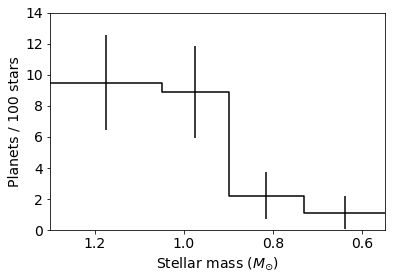

In [32]:
fig, ax = plt.subplots()
ax.step([2.83, 1.05, 0.90, 0.73, 0.5], [F_snows*100/len(four_lists[3]), 
                         F_snows*100/len(four_lists[3]),
                         G_snows*100/len(four_lists[2]), 
                         K_snows*100/len(four_lists[1]), 
                         M_snows*100/len(four_lists[0])], 
       color='black')

midpoints = 0.5*np.asarray([1.3+1.05, 1.05+0.9, 0.9+0.73, 0.73+0.55])
uppers = [F_snows*100/len(four_lists[3]) + np.sqrt(F_snows*100/len(four_lists[3])), 
          G_snows*100/len(four_lists[2]) + np.sqrt(G_snows*100/len(four_lists[2])),
          K_snows*100/len(four_lists[1]) + np.sqrt(K_snows*100/len(four_lists[1])), 
          M_snows*100/len(four_lists[0]) + np.sqrt(M_snows*100/len(four_lists[0]))]
lowers = [F_snows*100/len(four_lists[3]) - np.sqrt(F_snows*100/len(four_lists[3])), 
          G_snows*100/len(four_lists[2]) - np.sqrt(G_snows*100/len(four_lists[2])),
          K_snows*100/len(four_lists[1]) - np.sqrt(K_snows*100/len(four_lists[1])), 
          M_snows*100/len(four_lists[0]) - np.sqrt(M_snows*100/len(four_lists[0]))]
ax.vlines(midpoints, lowers, uppers)

ax.set_xlim([1.3, 0.55])
ax.set_ylim([0, 14])
ax.set_xlabel(r'Stellar mass ($M_{\odot}$)')
ax.set_ylabel('Planets / 100 stars')
fig.savefig('basic_histogram.pdf')

In [35]:
print(np.percentile(specmatch.fe_c, 0),  np.percentile(specmatch.fe_c, 25),
      np.percentile(specmatch.fe_c, 50), np.percentile(specmatch.fe_c, 75),
      np.percentile(specmatch.fe_c, 100))

-1.86310556997 -0.123728105941 0.028870729944700007 0.166237965271 0.54


In [37]:
n = int(719/8) + 1
eight_lists = [sorted_by_mass[i:i + n] for i in range(0, len(sorted_by_mass), n)]
eight_vs    = [sorted_by_mass_vs[i:i + n] for i in range(0, len(sorted_by_mass_vs), n)]

In [38]:
counts = [len(snow_giants.query('hostname in @eight_lists[@i]')) for i in range(8)]

In [39]:
counts

[1, 1, 0, 4, 2, 14, 6, 11]

In [40]:
eight_vs[0][-1]

0.495580556413

Text(0.5, 0, 'Stellar mass ($M_{\\odot}$)')

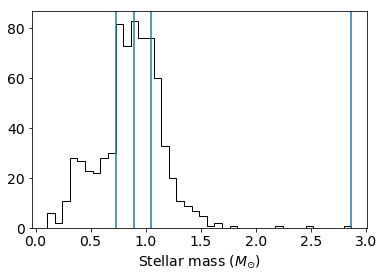

In [41]:
fig, ax = plt.subplots()
ax.hist(specmatch.mass_c, bins=40, histtype='step', color='black')
ax.axvline(eight_vs[1][-1])
ax.axvline(eight_vs[3][-1])
ax.axvline(eight_vs[5][-1])
ax.axvline(eight_vs[7][-1])

ax.set_xlabel(r'Stellar mass ($M_{\odot}$)')

In [42]:
eight_vs[3][-1] - eight_vs[1][-1]

0.16476588562000005

In [43]:
eight_vs[5][-1] - eight_vs[3][-1]

0.154221442993

### Go from 0.3 to 1.5 solar masses. Eight bins of 0.15 solar masses, or six bins of 0.2 solar masses.

In [23]:
np.std(specmatch.mass_err_c)

0.02306908143112845

In [24]:
np.logspace(np.log10(0.3), np.log10(1.5), num=8)

array([0.3       , 0.37754969, 0.47514588, 0.59797059, 0.75254537,
       0.94707755, 1.19189611, 1.5       ])

In [25]:
specmatch_lim         = specmatch.query('mass_c >= 0.3 and mass_c < 1.5')
sorted_by_mass_lim    = np.asarray(specmatch_lim.name)[np.argsort(specmatch_lim.mass_c)]
sorted_by_mass_lim_vs = np.sort(specmatch_lim.mass_c)

six_lists = []
six_lists.append(np.asarray(specmatch.query('mass_c >= 0.3 and mass_c < 0.5').name))
six_lists.append(np.asarray(specmatch.query('mass_c >= 0.5 and mass_c < 0.7').name))
six_lists.append(np.asarray(specmatch.query('mass_c >= 0.7 and mass_c < 0.9').name))
six_lists.append(np.asarray(specmatch.query('mass_c >= 0.9 and mass_c < 1.1').name))
six_lists.append(np.asarray(specmatch.query('mass_c >= 1.1 and mass_c < 1.3').name))
six_lists.append(np.asarray(specmatch.query('mass_c >= 1.3 and mass_c < 1.5').name))

In [26]:
len(six_lists[4])

96

In [27]:
for i in range(6):
    with open('stellar_mass_{}.csv'.format(i+1), 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['name'])
        for val in six_lists[i]:
            writer.writerow([val])

In [28]:
samples_all = pd.read_csv('../legacy_samples/samples_all_1000.csv').sample(500).reset_index(drop=True)
good_cols = [col for col in samples_all.columns if '_a' in col or '_M' in col]
samples_all = samples_all[good_cols]
samples_med = samples_all.median()
planetnames = np.unique([x[:-2] + x[-1] for x in samples_all.columns]) 

for col in good_cols:
    if '_M' in col:
        samples_all[col] *= 317.8

specmatch_lim         = specmatch.query('mass_c >= 0.3 and mass_c < 1.5')
sorted_by_mass_lim    = np.asarray(specmatch_lim.name)[np.argsort(specmatch_lim.mass_c)]
sorted_by_mass_lim_vs = np.sort(specmatch_lim.mass_c)

six_lists = []
six_lists.append(np.asarray(specmatch.query('mass_c >= 0.3 and mass_c < 0.5').name))
six_lists.append(np.asarray(specmatch.query('mass_c >= 0.5 and mass_c < 0.7').name))
six_lists.append(np.asarray(specmatch.query('mass_c >= 0.7 and mass_c < 0.9').name))
six_lists.append(np.asarray(specmatch.query('mass_c >= 0.9 and mass_c < 1.1').name))
six_lists.append(np.asarray(specmatch.query('mass_c >= 1.1 and mass_c < 1.3').name))
six_lists.append(np.asarray(specmatch.query('mass_c >= 1.3 and mass_c < 1.5').name))

columns_1 = []
columns_2 = []
columns_3 = []
columns_4 = []
columns_5 = []
columns_6 = []

for planet in planetnames:
    stellarname = planet[:-2]
    a_col = stellarname + '_a' + planet[-1]
    M_col = stellarname + '_M' + planet[-1]
    if (stellarname in six_lists[0]) and (samples_med[a_col] >= 1) and (samples_med[a_col] < 5) and \
                                         (samples_med[M_col] >= 100/317.8) and (samples_med[M_col] < 6000/317.8):
        columns_1.append(a_col)
        columns_1.append(M_col)
    if (stellarname in six_lists[1]) and (samples_med[a_col] >= 1) and (samples_med[a_col] < 5) and \
                                         (samples_med[M_col] >= 100/317.8) and (samples_med[M_col] < 6000/317.8):
        columns_2.append(a_col)
        columns_2.append(M_col)
    if (stellarname in six_lists[2]) and (samples_med[a_col] >= 1) and (samples_med[a_col] < 5) and \
                                         (samples_med[M_col] >= 100/317.8) and (samples_med[M_col] < 6000/317.8):
        columns_3.append(a_col)
        columns_3.append(M_col)
    if (stellarname in six_lists[3]) and (samples_med[a_col] >= 1) and (samples_med[a_col] < 5) and \
                                         (samples_med[M_col] >= 100/317.8) and (samples_med[M_col] < 6000/317.8):
        columns_4.append(a_col)
        columns_4.append(M_col)
    if (stellarname in six_lists[4]) and (samples_med[a_col] >= 1) and (samples_med[a_col] < 5) and \
                                         (samples_med[M_col] >= 100/317.8) and (samples_med[M_col] < 6000/317.8):
        columns_5.append(a_col)
        columns_5.append(M_col)
    if (stellarname in six_lists[5]) and (samples_med[a_col] >= 1) and (samples_med[a_col] < 5) and \
                                         (samples_med[M_col] >= 100/317.8) and (samples_med[M_col] < 6000/317.8):
        columns_6.append(a_col)
        columns_6.append(M_col)
        
samples_1 = samples_all[columns_1]
samples_2 = samples_all[columns_2]
samples_3 = samples_all[columns_3]
samples_4 = samples_all[columns_4]
samples_5 = samples_all[columns_5]
samples_6 = samples_all[columns_6]

"\nfor col in good_cols:\n    if '_M' in col:\n        samples_all[col] *= 317.8\n        \nfor col in columns_1:\n    if '_M' in col:\n        samples_1[col] *= 317.8\nfor col in columns_2:\n    if '_M' in col:\n        samples_2[col] *= 317.8\nfor col in columns_3:\n    if '_M' in col:\n        samples_3[col] *= 317.8\nfor col in columns_4:\n    if '_M' in col:\n        samples_4[col] *= 317.8\nfor col in columns_5:\n    if '_M' in col:\n        samples_5[col] *= 317.8\nfor col in columns_6:\n    if '_M' in col:\n        samples_6[col] *= 317.8\n"

In [30]:
recoveries_1 = pd.read_csv('../recovery_files/recoveries_stellar_mass_1.csv')
completey_1  = Completeness(recoveries_1)
completey_1.completeness_grid([0.01, 40], [2, 9000])

recoveries_2 = pd.read_csv('../recovery_files/recoveries_stellar_mass_2.csv')
completey_2  = Completeness(recoveries_2)
completey_2.completeness_grid([0.01, 40], [2, 9000])

recoveries_3 = pd.read_csv('../recovery_files/recoveries_stellar_mass_3.csv')
completey_3  = Completeness(recoveries_3)
completey_3.completeness_grid([0.01, 40], [2, 9000])

recoveries_4 = pd.read_csv('../recovery_files/recoveries_stellar_mass_4.csv')
completey_4  = Completeness(recoveries_4)
completey_4.completeness_grid([0.01, 40], [2, 9000])

recoveries_5 = pd.read_csv('../recovery_files/recoveries_stellar_mass_5.csv')
completey_5  = Completeness(recoveries_5)
completey_5.completeness_grid([0.01, 40], [2, 9000])

recoveries_6 = pd.read_csv('../recovery_files/recoveries_stellar_mass_6.csv')
completey_6  = Completeness(recoveries_6)
completey_6.completeness_grid([0.01, 40], [2, 9000])

In [31]:
gasbin = lngrid(1, 5, 100, 6000, 1, 1) 
hierarchical_1 = Hierarchy(samples_1, completey_1, bins=gasbin, chainname='chains/occur_chains_1.csv')
hierarchical_1.max_like()
hierarchical_1.sample()

hierarchical_2 = Hierarchy(samples_2, completey_2, bins=gasbin, chainname='chains/occur_chains_2.csv')
hierarchical_2.max_like()
hierarchical_2.sample()

hierarchical_3 = Hierarchy(samples_3, completey_3, bins=gasbin, chainname='chains/occur_chains_3.csv')
hierarchical_3.max_like()
hierarchical_3.sample()

hierarchical_4 = Hierarchy(samples_4, completey_4, bins=gasbin, chainname='chains/occur_chains_4.csv')
hierarchical_4.max_like()
hierarchical_4.sample()

hierarchical_5 = Hierarchy(samples_5, completey_5, bins=gasbin, chainname='chains/occur_chains_5.csv')
hierarchical_5.max_like()
hierarchical_5.sample()

hierarchical_6 = Hierarchy(samples_6, completey_6, bins=gasbin, chainname='chains/occur_chains_6.csv')
hierarchical_6.max_like()
hierarchical_6.sample()

100%|██████████| 1000/1000 [00:15<00:00, 63.37it/s]


In [32]:
planets_merge = pd.merge(planets, specmatch, left_on='hostname', right_on='name')

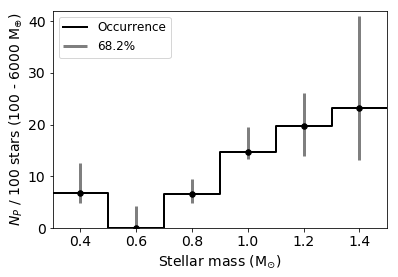

In [42]:
matplotlib.rcParams.update({'font.size': 14})

s_modes = []
s_159 = []
s_841 = []
s_682 = []

chains = hierarchical_1.chains*hierarchical_1.bin_areas[0][0]*(100/len(six_lists[0]))
hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
s_modes.append(bin_edges[np.argmax(hist)])
s_159.append(np.percentile(chains, 15.9))
s_841.append(np.percentile(chains, 84.1))

chains = hierarchical_2.chains*hierarchical_2.bin_areas[0][0]*(100/len(six_lists[1]))
hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
s_modes.append(bin_edges[np.argmax(hist)])
s_159.append(np.percentile(chains, 15.9))
s_841.append(np.percentile(chains, 84.1))

chains = hierarchical_3.chains*hierarchical_3.bin_areas[0][0]*(100/len(six_lists[2]))
hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
s_modes.append(bin_edges[np.argmax(hist)])
s_159.append(np.percentile(chains, 15.9))
s_841.append(np.percentile(chains, 84.1))

chains = hierarchical_4.chains*hierarchical_4.bin_areas[0][0]*(100/len(six_lists[3]))
hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
s_modes.append(bin_edges[np.argmax(hist)])
s_159.append(np.percentile(chains, 15.9))
s_841.append(np.percentile(chains, 84.1))

chains = hierarchical_5.chains*hierarchical_5.bin_areas[0][0]*(100/len(six_lists[4]))
hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
s_modes.append(bin_edges[np.argmax(hist)])
s_159.append(np.percentile(chains, 15.9))
s_841.append(np.percentile(chains, 84.1))

chains = hierarchical_6.chains*hierarchical_6.bin_areas[0][0]*(100/len(six_lists[5]))
hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
s_modes.append(bin_edges[np.argmax(hist)])
s_159.append(np.percentile(chains, 15.9))
s_841.append(np.percentile(chains, 84.1))

s_modes = np.array(s_modes)
s_159 = np.array(s_159)
s_841 = np.array(s_841)

fig, ax = plt.subplots()

ax.set_xlabel(r'Stellar mass (M$_{\odot}$)')
ax.set_ylabel(r'$N_P$ / 100 stars (100 - 6000 $\mathrm{M_{\oplus}}$)')
ax.set_xlim([0.3, 1.5])
ax.set_ylim([0, 42])
lnsw = 0.2

stellars = np.asarray([0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5])

# Do simple counting.
simple_counts = []
for n in np.arange(len(stellars) - 1):
    s1 = stellars[n]
    s2 = stellars[n+1]
    npl = len(planets_merge.query('mass>=100/317.8 and mass<6000/317.8 and axis>=1 and axis<5 and mass_c>=@s1 and mass_c<@s2'))
    simple_counts.append(npl)    
simple_counts = np.array(simple_counts)/len(specmatch.query('mass_c>=@s1 and mass_c<@s2'))*100

# Plot just-counting histogram.
#ax.step(stellars, np.insert(simple_counts, 0, simple_counts[0]), lw=2, c='blue', linestyle=':', label='Count')

# Plot occurrence histogram.
ax.step(stellars, np.insert(s_modes, 0, s_modes[0]), color='black', lw=2, label='Occurrence')
# Plot mode & 68.2% CI.
ax.scatter(stellars[:-1] + 0.5*lnsw, s_modes, color='black', s=30, label='_nolegend_')
ax.vlines(stellars[:-1] + 0.5*lnsw, s_159, s_841, alpha=0.5, color='black', lw=3, label='68.2%')

ax.legend(loc=2, fontsize=12) 

#fig.savefig('hist_11x1_1014_fancy_mode.png', dpi=1000, bbox_inches='tight')
fig.savefig('plots/stellar_mass_occurrence.pdf', bbox_inches='tight')

(array([ 6.,  2., 11., 28., 27., 23., 22., 28., 30., 82., 73., 83., 76.,
        76., 60., 33., 20., 11.,  9.,  7.,  5.,  1.,  2.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.]),
 array([0.10434646, 0.17339194, 0.24243741, 0.31148289, 0.38052836,
        0.44957384, 0.51861931, 0.58766479, 0.65671026, 0.72575574,
        0.79480121, 0.86384669, 0.93289216, 1.00193764, 1.07098311,
        1.14002859, 1.20907406, 1.27811954, 1.34716502, 1.41621049,
        1.48525597, 1.55430144, 1.62334692, 1.69239239, 1.76143787,
        1.83048334, 1.89952882, 1.96857429, 2.03761977, 2.10666524,
        2.17571072, 2.24475619, 2.31380167, 2.38284714, 2.45189262,
        2.52093809, 2.58998357, 2.65902904, 2.72807452, 2.79711999,
        2.86616547]),
 <a list of 1 Patch objects>)

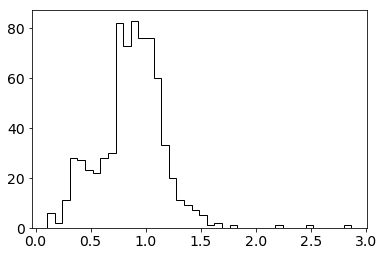

In [34]:
fig, ax = plt.subplots()
ax.hist(specmatch.mass_c, bins=40, histtype='step', color='black')

### Bin in [Fe/H] from -0.5 to 0.4. Try 6 bins.

In [35]:
np.linspace(-0.5, 0.4, 7)

array([-0.5 , -0.35, -0.2 , -0.05,  0.1 ,  0.25,  0.4 ])

In [36]:
six_lists_metal = []
six_lists_metal.append(np.asarray(specmatch.query('fe_c >= -0.5 and fe_c < -0.35').name))
six_lists_metal.append(np.asarray(specmatch.query('fe_c >= -0.35 and fe_c < -0.2').name))
six_lists_metal.append(np.asarray(specmatch.query('fe_c >= -0.2 and fe_c < -0.05').name))
six_lists_metal.append(np.asarray(specmatch.query('fe_c >= -0.05 and fe_c < 0.1').name))
six_lists_metal.append(np.asarray(specmatch.query('fe_c >= 0.1 and fe_c < 0.25').name))
six_lists_metal.append(np.asarray(specmatch.query('fe_c >= 0.25 and fe_c < 0.4').name))

In [54]:
six_lists_metal

[array(['102158', '104556', '10700', '110897', '111515', '139457',
        '142267', '14412', '158633', '160693', '16397', '16623', '19034',
        '190404', '21019a', '218209', '219953', '24238', '24341', '283',
        '30649', '37213', '48938', '56274', '6734', '73667', '1326',
        '201092', '225213', '95735', 'gl239', 'gl412a', 'gl625', 'gl745a',
        'gl745b', 'gl87', 'gl908', 'hip104432', 'hip36834', 'hip60559'],
       dtype=object),
 array(['100623', '112914', '114729', '114946', '116442', '116443',
        '126053', '130004', '132142', '136352', '136925', '143291',
        '145809', '150433', '152792', '157214', '159062', '161848',
        '165401', '167215', '167216', '172051', '172310', '176377',
        '190067', '199476', '2025', '210460', '211038', '214683', '220339',
        '22072', '221356', '225261', '24365', '24892', '28187', '37008',
        '37124', '4208', '43947', '4614', '4628', '51419', '55575',
        '66171', '68017', '72673', '88371', '97658', '1198

In [37]:
columns_1 = []
columns_2 = []
columns_3 = []
columns_4 = []
columns_5 = []
columns_6 = []

for planet in planetnames:
    stellarname = planet[:-2]
    a_col = stellarname + '_a' + planet[-1]
    M_col = stellarname + '_M' + planet[-1]
    if (stellarname in six_lists_metal[0]) and (samples_med[a_col] >= 1) and (samples_med[a_col] < 5) and \
                                         (samples_med[M_col] >= 100/317.8) and (samples_med[M_col] < 6000/317.8):
        columns_1.append(a_col)
        columns_1.append(M_col)
        print(1)
    if (stellarname in six_lists_metal[1]) and (samples_med[a_col] >= 1) and (samples_med[a_col] < 5) and \
                                         (samples_med[M_col] >= 100/317.8) and (samples_med[M_col] < 6000/317.8):
        columns_2.append(a_col)
        columns_2.append(M_col)
        print(2)
    if (stellarname in six_lists_metal[2]) and (samples_med[a_col] >= 1) and (samples_med[a_col] < 5) and \
                                         (samples_med[M_col] >= 100/317.8) and (samples_med[M_col] < 6000/317.8):
        columns_3.append(a_col)
        columns_3.append(M_col)
        print(3)
    if (stellarname in six_lists_metal[3]) and (samples_med[a_col] >= 1) and (samples_med[a_col] < 5) and \
                                         (samples_med[M_col] >= 100/317.8) and (samples_med[M_col] < 6000/317.8):
        columns_4.append(a_col)
        columns_4.append(M_col)
        print(4)
    if (stellarname in six_lists_metal[4]) and (samples_med[a_col] >= 1) and (samples_med[a_col] < 5) and \
                                         (samples_med[M_col] >= 100/317.8) and (samples_med[M_col] < 6000/317.8):
        columns_5.append(a_col)
        columns_5.append(M_col)
        print(5)
    if (stellarname in six_lists_metal[5]) and (samples_med[a_col] >= 1) and (samples_med[a_col] < 5) and \
                                         (samples_med[M_col] >= 100/317.8) and (samples_med[M_col] < 6000/317.8):
        columns_6.append(a_col)
        columns_6.append(M_col)
        print(6)
samples_1_metal = samples_all[columns_1]
samples_2_metal = samples_all[columns_2]
samples_3_metal = samples_all[columns_3]
samples_4_metal = samples_all[columns_4]
samples_5_metal = samples_all[columns_5]
samples_6_metal = samples_all[columns_6]
'''
for col in columns_1:
    if '_M' in col:
        samples_1_metal[col] *= 317.8
for col in columns_2:
    if '_M' in col:
        samples_2_metal[col] *= 317.8
for col in columns_3:
    if '_M' in col:
        samples_3_metal[col] *= 317.8
for col in columns_4:
    if '_M' in col:
        samples_4_metal[col] *= 317.8
for col in columns_5:
    if '_M' in col:
        samples_5_metal[col] *= 317.8
for col in columns_6:
    if '_M' in col:
        samples_6_metal[col] *= 317.8
'''

5
5
5
2
5
5
5
5
6
5
5
6
6
4
3
5
4
4
5
6
6
6
4
5
6
5
5
4
4
5
5
5
4
3
5
2
2
6
6
2
6
6
4
6
4
4
5
5
4
4
5
6
6
6
6
5


"\nfor col in columns_1:\n    if '_M' in col:\n        samples_1_metal[col] *= 317.8\nfor col in columns_2:\n    if '_M' in col:\n        samples_2_metal[col] *= 317.8\nfor col in columns_3:\n    if '_M' in col:\n        samples_3_metal[col] *= 317.8\nfor col in columns_4:\n    if '_M' in col:\n        samples_4_metal[col] *= 317.8\nfor col in columns_5:\n    if '_M' in col:\n        samples_5_metal[col] *= 317.8\nfor col in columns_6:\n    if '_M' in col:\n        samples_6_metal[col] *= 317.8\n"

In [38]:
for i in range(6):
    with open('stellar_metallicity_{}.csv'.format(i+1), 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['name'])
        for val in six_lists_metal[i]:
            writer.writerow([val])

In [39]:
recoveries_1_metal = pd.read_csv('../recovery_files/recoveries_stellar_metallicity_1.csv')
completey_1_metal  = Completeness(recoveries_1_metal)
completey_1_metal.completeness_grid([0.01, 40], [2, 9000])

recoveries_2_metal = pd.read_csv('../recovery_files/recoveries_stellar_metallicity_2.csv')
completey_2_metal  = Completeness(recoveries_2_metal)
completey_2_metal.completeness_grid([0.01, 40], [2, 9000])

recoveries_3_metal = pd.read_csv('../recovery_files/recoveries_stellar_metallicity_3.csv')
completey_3_metal  = Completeness(recoveries_3_metal)
completey_3_metal.completeness_grid([0.01, 40], [2, 9000])

recoveries_4_metal = pd.read_csv('../recovery_files/recoveries_stellar_metallicity_4.csv')
completey_4_metal  = Completeness(recoveries_4_metal)
completey_4_metal.completeness_grid([0.01, 40], [2, 9000])

recoveries_5_metal = pd.read_csv('../recovery_files/recoveries_stellar_metallicity_5.csv')
completey_5_metal  = Completeness(recoveries_5_metal)
completey_5_metal.completeness_grid([0.01, 40], [2, 9000])

recoveries_6_metal = pd.read_csv('../recovery_files/recoveries_stellar_metallicity_6.csv')
completey_6_metal  = Completeness(recoveries_6_metal)
completey_6_metal.completeness_grid([0.01, 40], [2, 9000])

In [40]:
gasbin = lngrid(1, 5, 100, 6000, 1, 1) 
hierarchical_1_metal = Hierarchy(samples_1_metal, completey_1_metal, bins=gasbin, chainname='chains/occur_chains_metal_1.csv')
hierarchical_1_metal.max_like()
hierarchical_1_metal.sample()

hierarchical_2_metal = Hierarchy(samples_2_metal, completey_2_metal, bins=gasbin, chainname='chains/occur_chains_metal_2.csv')
hierarchical_2_metal.max_like()
hierarchical_2_metal.sample()

hierarchical_3_metal = Hierarchy(samples_3_metal, completey_3_metal, bins=gasbin, chainname='chains/occur_chains_metal_3.csv')
hierarchical_3_metal.max_like()
hierarchical_3_metal.sample()

hierarchical_4_metal = Hierarchy(samples_4_metal, completey_4_metal, bins=gasbin, chainname='chains/occur_chains_metal_4.csv')
hierarchical_4_metal.max_like()
hierarchical_4_metal.sample()

hierarchical_5_metal = Hierarchy(samples_5_metal, completey_5_metal, bins=gasbin, chainname='chains/occur_chains_metal_5.csv')
hierarchical_5_metal.max_like()
hierarchical_5_metal.sample()

hierarchical_6_metal = Hierarchy(samples_6_metal, completey_6_metal, bins=gasbin, chainname='chains/occur_chains_metal_6.csv')
hierarchical_6_metal.max_like()
hierarchical_6_metal.sample()

100%|██████████| 1000/1000 [00:36<00:00, 27.59it/s]


In [66]:
hierarchical_4_metal.mlvalues

array([[2.44152582, 0.70480779]])

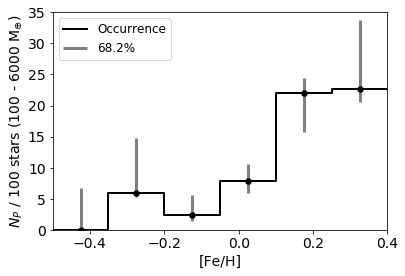

In [44]:
matplotlib.rcParams.update({'font.size': 14})

s_modes = []
s_159 = []
s_841 = []
s_682 = []

chains = hierarchical_1_metal.chains*hierarchical_1_metal.bin_areas[0][0]*(100/len(six_lists_metal[0]))
hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
s_modes.append(bin_edges[np.argmax(hist)])
s_159.append(np.percentile(chains, 15.9))
s_841.append(np.percentile(chains, 84.1))

chains = hierarchical_2_metal.chains*hierarchical_2_metal.bin_areas[0][0]*(100/len(six_lists_metal[1]))
hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
s_modes.append(bin_edges[np.argmax(hist)])
s_159.append(np.percentile(chains, 15.9))
s_841.append(np.percentile(chains, 84.1))

chains = hierarchical_3_metal.chains*hierarchical_3_metal.bin_areas[0][0]*(100/len(six_lists_metal[2]))
hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
s_modes.append(bin_edges[np.argmax(hist)])
s_159.append(np.percentile(chains, 15.9))
s_841.append(np.percentile(chains, 84.1))

chains = hierarchical_4_metal.chains*hierarchical_4_metal.bin_areas[0][0]*(100/len(six_lists_metal[3]))
hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
s_modes.append(bin_edges[np.argmax(hist)])
s_159.append(np.percentile(chains, 15.9))
s_841.append(np.percentile(chains, 84.1))

chains = hierarchical_5_metal.chains*hierarchical_5_metal.bin_areas[0][0]*(100/len(six_lists_metal[4]))
hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
s_modes.append(bin_edges[np.argmax(hist)])
s_159.append(np.percentile(chains, 15.9))
s_841.append(np.percentile(chains, 84.1))

chains = hierarchical_6_metal.chains*hierarchical_6_metal.bin_areas[0][0]*(100/len(six_lists_metal[5]))
hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
s_modes.append(bin_edges[np.argmax(hist)])
s_159.append(np.percentile(chains, 15.9))
s_841.append(np.percentile(chains, 84.1))

s_modes = np.array(s_modes)
s_159 = np.array(s_159)
s_841 = np.array(s_841)

fig, ax = plt.subplots()

ax.set_xlabel(r'[Fe/H]')
ax.set_ylabel(r'$N_P$ / 100 stars (100 - 6000 $\mathrm{M_{\oplus}}$)')
ax.set_xlim([-0.5, 0.4])
ax.set_ylim([0, 35])
lnsw = 0.15

stellars = np.linspace(-0.5, 0.4, 7)

# Plot occurrence step function.
ax.step(stellars, np.insert(s_modes, 0, s_modes[0]), color='black', lw=2, label='Occurrence')
# Plot mode & 68.2% CI.
ax.scatter(stellars[:-1] + 0.5*lnsw, s_modes, color='black', s=30, label='_nolegend_')
ax.vlines(stellars[:-1] + 0.5*lnsw, s_159, s_841, alpha=0.5, color='black', lw=3, label='68.2%')

ax.legend(loc=2, fontsize=12) 

#fig.savefig('hist_11x1_1014_fancy_mode.png', dpi=1000, bbox_inches='tight')
fig.savefig('plots/stellar_metallicity_occurrence.pdf', bbox_inches='tight')

### Check out mass vs. metallicity for planet hosts.

In [7]:
planet_host_names = np.unique(planets.query('mass >= 0.1').hostname)
specmatch_planets   = specmatch.query('name in @planet_host_names')
specmatch_noplanets = specmatch.query('name not in @planet_host_names')

In [8]:
len(specmatch_planets)

96

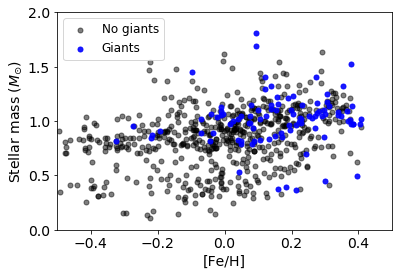

In [10]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
ax.scatter(specmatch_noplanets.fe_c, specmatch_noplanets.mass_c, c='black', alpha=0.5, label='No giants')
ax.scatter(specmatch_planets.fe_c, specmatch_planets.mass_c, c='blue', alpha=0.9, label='Giants')

ax.set_xlabel('[Fe/H]')
ax.set_ylabel(r'Stellar mass ($M_{\odot}$)')
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0, 2])
ax.legend(fontsize=12)
fig.savefig('plots/mass_vs_metallicity.pdf', bbox_inches='tight')

(-0.5, 0.5)

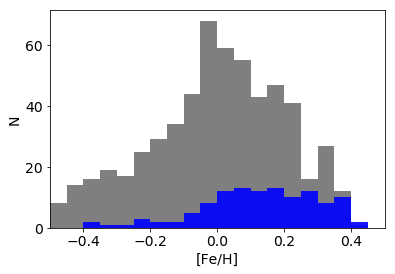

In [94]:
fig, ax = plt.subplots()
ax.hist(specmatch_noplanets.fe_c, color='black', alpha=0.5, bins=20, range=[-0.5, 0.5])
ax.hist(specmatch_planets.fe_c, color='blue', alpha=0.9, bins=20, range=[-0.5, 0.5])

ax.set_xlabel('[Fe/H]')
ax.set_ylabel('N')
ax.set_xlim([-0.5, 0.5])

(0.3, 1.5)

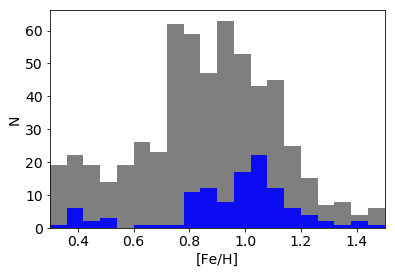

In [96]:
fig, ax = plt.subplots()
ax.hist(specmatch_noplanets.mass_c, color='black', alpha=0.5, bins=20, range=[0.3, 1.5])
ax.hist(specmatch_planets.mass_c, color='blue', alpha=0.9, bins=20, range=[0.3, 1.5])

ax.set_xlabel('[Fe/H]')
ax.set_ylabel('N')
ax.set_xlim([0.3, 1.5])

### Estimate the mass function beyond the ice line.

In [9]:
recoveries_all = pd.read_csv('../recovery_files/recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)
completey_all.completeness_grid([0.01, 40], [2, 9000])

In [10]:
massbins = lngrid(1, 5, 30., 3000, 1, 4) 

In [14]:
hierarchical_mass = Hierarchy(samples_all, completey_all, bins=massbins, chainname='chains/occur_chains_mass_function.csv')
hierarchical_mass.max_like()

In [15]:
hierarchical_mass.mlvalues

array([[16.00717098,  7.15862449],
       [22.74548552,  5.08604518],
       [17.11130923,  3.49283137],
       [ 8.12566223,  2.25365322]])

In [16]:
hierarchical_mass.sample()

  1%|          | 7/1000 [00:07<18:47,  1.14s/it]Traceback (most recent call last):
  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/lee/Academics/Astronomy/Planets/CLSIV/occur.py", line 247, in lnpost
    return self.lnlike(theta)
  File "/Users/lee/Academics/Astronomy/Planets/CLSIV/occur.py", line 225, in lnlike
    sample_M = np.array(self.pop[planet[:-2] + '_M' + planet[-1]])
  File "/Users/lee/anaconda/lib/python3.7/site-packages/pandas/core/frame.py", line 2966, in __getitem__
    key = com.apply_if_callable(key, self)
KeyboardInterrupt
  1%|          | 7/1000 [00:08<20:31,  1.24s/it]

emcee: Exception while calling your likelihood function:
  params: [16.01188221 22.74676944 17.12319709  8.11400548]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

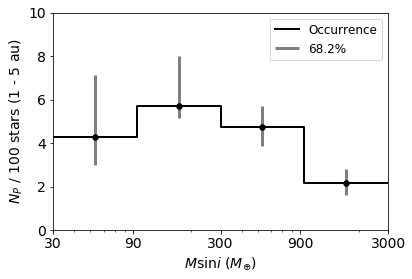

In [80]:
matplotlib.rcParams.update({'font.size': 14})
chains_db = pd.read_csv('chains/occur_chains_mass_function.csv')

binwidth = massbins[0][1][1] - massbins[0][1][0]

# Do simple counting.
#simple_counts = []
#for n in np.arange(hierarchical_mass.nbins):
#    a1 = np.exp(allbins[n][0][0])
#    a2 = np.exp(allbins[n][0][1])
#    npl = len(planets.query('mass >= 0.1 and axis >= @a1 and axis < @a2'))
#    simple_counts.append(npl)    
#simple_counts = np.array(simple_counts)*(100/719)/binwidth

m_chains = np.empty((0, len(chains_db)))
for n in np.arange(hierarchical_mass.nbins):
    m_chains = np.append(m_chains, np.array([chains_db['gamma{}'.format(n)]]), axis=0)
m_chains *= hierarchical_mass.bin_areas[0][0]*(100/719)#/binwidth

# Record modes & medians.
a_medians = np.median(m_chains, axis=1)
m_sqvars  = np.std(m_chains, axis=1)
m_modes = []
m_159 = []
m_841 = []
m_682 = []

for n in np.arange(hierarchical_mass.nbins):
    chains = np.array([chains_db['gamma{}'.format(n)]])*hierarchical_mass.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    m_modes.append(bin_edges[np.argmax(hist)])
    m_159.append(np.percentile(chains, 15.9))
    m_841.append(np.percentile(chains, 84.1))
    m_682.append(np.percentile(chains, 68.2))
m_modes = np.array(m_modes)#/binwidth
m_159 = np.array(m_159)#/binwidth
m_841 = np.array(m_841)#/binwidth
m_682 = np.array(m_682)#/binwidth

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xticks((30, 90, 300, 900, 3000))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.set_ylabel(r'$N_P$ / 100 stars (1 - 5 au)')
#ax.set_ylabel(r'$N_P$ / 100 stars / $\Delta$ln($M$sin$i$) (0.8 - 5 au)')
ax.set_xlim([np.exp(hierarchical_mass.lnm_edges[0]), np.exp(hierarchical_mass.lnm_edges[-1])])
ax.set_ylim([0, 10])
lnmw = hierarchical_mass.lnm_edges[1] - hierarchical_mass.lnm_edges[0]

# Plot just-counting, no-completeness histogram.
#ax.step(np.insert(np.exp(hierarchical_mass.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_mass.lna_edges[0])), 
#        np.insert(simple_counts, 0, simple_counts[0]), lw=2, c='blue', linestyle=':', label='Count')

# Plot mode & 68.2% CI.
ax.scatter(np.exp(hierarchical_mass.lnm_edges[:-1] + 0.5*lnmw), m_modes,
           color='black', s=30, label='_nolegend_')#label='Occurrence mode & CI')
ax.vlines(np.exp(hierarchical_mass.lnm_edges[:-1] + 0.5*lnmw), m_159,
          m_841, alpha=0.5, color='black', lw=3, label='68.2%')

# Plot occurrence histogram.
ax.step(np.insert(np.exp(hierarchical_mass.lnm_edges[:-1] + lnmw), 0, np.exp(hierarchical_mass.lnm_edges[0])), 
        np.insert(m_modes, 0, m_modes[0]), color='black', lw=2, label='Occurrence')
 
ax.legend(loc=1, fontsize=12) 

fig.savefig('plots/beyond_ice_line_mass_function.png', dpi=1000, bbox_inches='tight')
fig.savefig('plots/beyond_ice_line_mass_function.pdf', bbox_inches='tight')

In [17]:
#massbins_close = lngrid(0.03, 1, 30., 3000, 1, 4) 
massbins_close = lngrid(0.2, 1, 30., 3000, 1, 4) 
hierarchical_mass_close = Hierarchy(samples_all, completey_all, bins=massbins_close, chainname='chains/occur_chains_mass_function_close.csv')
hierarchical_mass_close.max_like()

In [99]:
hierarchical_mass_close.sample()

100%|██████████| 1000/1000 [17:21<00:00,  1.04s/it]


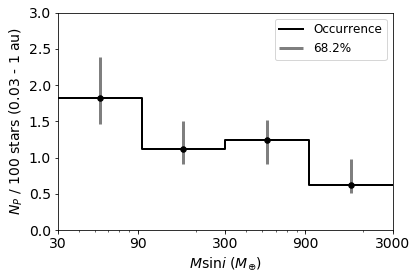

In [101]:
matplotlib.rcParams.update({'font.size': 14})
chains_db = pd.read_csv('chains/occur_chains_mass_function_close.csv')

binwidth = massbins[0][1][1] - massbins[0][1][0]

m_chains = np.empty((0, len(chains_db)))
for n in np.arange(hierarchical_mass.nbins):
    m_chains = np.append(m_chains, np.array([chains_db['gamma{}'.format(n)]]), axis=0)
m_chains *= hierarchical_mass.bin_areas[0][0]*(100/719)#/binwidth

# Record modes & medians.
a_medians = np.median(m_chains, axis=1)
m_sqvars  = np.std(m_chains, axis=1)
m_modes = []
m_159 = []
m_841 = []
m_682 = []

for n in np.arange(hierarchical_mass.nbins):
    chains = np.array([chains_db['gamma{}'.format(n)]])*hierarchical_mass.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    m_modes.append(bin_edges[np.argmax(hist)])
    m_159.append(np.percentile(chains, 15.9))
    m_841.append(np.percentile(chains, 84.1))
    m_682.append(np.percentile(chains, 68.2))
m_modes = np.array(m_modes)#/binwidth
m_159 = np.array(m_159)#/binwidth
m_841 = np.array(m_841)#/binwidth
m_682 = np.array(m_682)#/binwidth

#pdb.set_trace()

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xticks((30, 90, 300, 900, 3000))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.set_ylabel(r'$N_P$ / 100 stars (0.03 - 1 au)')
#ax.set_ylabel(r'$N_P$ / 100 stars / $\Delta$ln($M$sin$i$) (0.8 - 5 au)')
ax.set_xlim([np.exp(hierarchical_mass.lnm_edges[0]), np.exp(hierarchical_mass.lnm_edges[-1])])
ax.set_ylim([0, 3])
lnmw = hierarchical_mass.lnm_edges[1] - hierarchical_mass.lnm_edges[0]

# Plot just-counting, no-completeness histogram.
#ax.step(np.insert(np.exp(hierarchical_mass.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_mass.lna_edges[0])), 
#        np.insert(simple_counts, 0, simple_counts[0]), lw=2, c='blue', linestyle=':', label='Count')

# Plot mode & 68.2% CI.
ax.scatter(np.exp(hierarchical_mass.lnm_edges[:-1] + 0.5*lnmw), m_modes,
           color='black', s=30, label='_nolegend_')#label='Occurrence mode & CI')
ax.vlines(np.exp(hierarchical_mass.lnm_edges[:-1] + 0.5*lnmw), m_159,
          m_841, alpha=0.5, color='black', lw=3, label='68.2%')

# Plot occurrence histogram.
ax.step(np.insert(np.exp(hierarchical_mass.lnm_edges[:-1] + lnmw), 0, np.exp(hierarchical_mass.lnm_edges[0])), 
        np.insert(m_modes, 0, m_modes[0]), color='black', lw=2, label='Occurrence')
 
ax.legend(loc=1, fontsize=12) 

fig.savefig('plots/beyond_ice_line_mass_function_close.png', dpi=1000, bbox_inches='tight')
fig.savefig('plots/beyond_ice_line_mass_function_close.pdf', bbox_inches='tight')

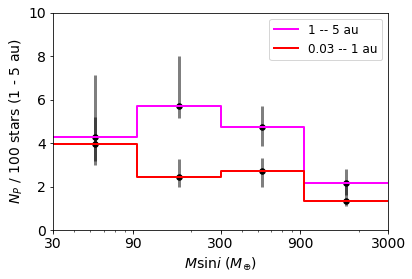

In [18]:
matplotlib.rcParams.update({'font.size': 14})
chains_db = pd.read_csv('chains/occur_chains_mass_function.csv')
chains_db_close = pd.read_csv('chains/occur_chains_mass_function_close.csv')

binwidth = massbins[0][1][1] - massbins[0][1][0]

# Do simple counting.
#simple_counts = []
#for n in np.arange(hierarchical_mass.nbins):
#    a1 = np.exp(allbins[n][0][0])
#    a2 = np.exp(allbins[n][0][1])
#    npl = len(planets.query('mass >= 0.1 and axis >= @a1 and axis < @a2'))
#    simple_counts.append(npl)    
#simple_counts = np.array(simple_counts)*(100/719)/binwidth

m_chains = np.empty((0, len(chains_db)))
for n in np.arange(hierarchical_mass.nbins):
    m_chains = np.append(m_chains, np.array([chains_db['gamma{}'.format(n)]]), axis=0)
m_chains *= hierarchical_mass.bin_areas[0][0]*(100/719)#/binwidth

# Record modes & medians.
a_medians = np.median(m_chains, axis=1)
m_sqvars  = np.std(m_chains, axis=1)
m_modes = []
m_159 = []
m_841 = []
m_682 = []

for n in np.arange(hierarchical_mass.nbins):
    chains = np.array([chains_db['gamma{}'.format(n)]])*hierarchical_mass.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    m_modes.append(bin_edges[np.argmax(hist)])
    m_159.append(np.percentile(chains, 15.9))
    m_841.append(np.percentile(chains, 84.1))
    m_682.append(np.percentile(chains, 68.2))
m_modes = np.array(m_modes)#/binwidth
m_159 = np.array(m_159)#/binwidth
m_841 = np.array(m_841)#/binwidth
m_682 = np.array(m_682)#/binwidth

#pdb.set_trace()

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xticks((30, 90, 300, 900, 3000))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.set_ylabel(r'$N_P$ / 100 stars (1 - 5 au)')
#ax.set_ylabel(r'$N_P$ / 100 stars / $\Delta$ln($M$sin$i$) (0.8 - 5 au)')
ax.set_xlim([np.exp(hierarchical_mass.lnm_edges[0]), np.exp(hierarchical_mass.lnm_edges[-1])])
ax.set_ylim([0, 10])
lnmw = hierarchical_mass.lnm_edges[1] - hierarchical_mass.lnm_edges[0]

# Plot just-counting, no-completeness histogram.
#ax.step(np.insert(np.exp(hierarchical_mass.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_mass.lna_edges[0])), 
#        np.insert(simple_counts, 0, simple_counts[0]), lw=2, c='blue', linestyle=':', label='Count')

# Plot mode & 68.2% CI.
ax.scatter(np.exp(hierarchical_mass.lnm_edges[:-1] + 0.5*lnmw), m_modes,
           color='black', s=30, label='_nolegend_')#label='Occurrence mode & CI')
ax.vlines(np.exp(hierarchical_mass.lnm_edges[:-1] + 0.5*lnmw), m_159,
          m_841, alpha=0.5, color='black', lw=3, label='_nolegend_')

# Plot occurrence histogram.
ax.step(np.insert(np.exp(hierarchical_mass.lnm_edges[:-1] + lnmw), 0, np.exp(hierarchical_mass.lnm_edges[0])), 
        np.insert(m_modes, 0, m_modes[0]), color='magenta', lw=2, label=r'1 -- 5 au')
 
    

m_chains = np.empty((0, len(chains_db_close)))
for n in np.arange(hierarchical_mass_close.nbins):
    m_chains = np.append(m_chains, np.array([chains_db_close['gamma{}'.format(n)]]), axis=0)
m_chains *= hierarchical_mass_close.bin_areas[0][0]*(100/719)#/binwidth

# Record modes & medians.
a_medians = np.median(m_chains, axis=1)
m_sqvars  = np.std(m_chains, axis=1)
m_modes = []
m_159 = []
m_841 = []
m_682 = []

for n in np.arange(hierarchical_mass_close.nbins):
    chains = np.array([chains_db_close['gamma{}'.format(n)]])*hierarchical_mass_close.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    m_modes.append(bin_edges[np.argmax(hist)])
    m_159.append(np.percentile(chains, 15.9))
    m_841.append(np.percentile(chains, 84.1))
    m_682.append(np.percentile(chains, 68.2))
m_modes = np.array(m_modes)#/binwidth
m_159 = np.array(m_159)#/binwidth
m_841 = np.array(m_841)#/binwidth
m_682 = np.array(m_682)#/binwidth

ax.set_xlim([np.exp(hierarchical_mass_close.lnm_edges[0]), np.exp(hierarchical_mass_close.lnm_edges[-1])])
ax.set_ylim([0, 10])
lnmw = hierarchical_mass_close.lnm_edges[1] - hierarchical_mass_close.lnm_edges[0]

# Plot mode & 68.2% CI.
ax.scatter(np.exp(hierarchical_mass_close.lnm_edges[:-1] + 0.5*lnmw), m_modes,
           color='black', s=30, label='_nolegend_')#label='Occurrence mode & CI')
ax.vlines(np.exp(hierarchical_mass_close.lnm_edges[:-1] + 0.5*lnmw), m_159,
          m_841, alpha=0.5, color='black', lw=3, label='_nolegend_')

# Plot occurrence histogram.
ax.step(np.insert(np.exp(hierarchical_mass_close.lnm_edges[:-1] + lnmw), 0, np.exp(hierarchical_mass_close.lnm_edges[0])), 
        np.insert(m_modes, 0, m_modes[0]), color='red', lw=2, label=r'0.03 -- 1 au')    
    
    
ax.legend(loc=1, fontsize=12) 
fig.savefig('plots/beyond_and_within_ice_line_mass_function.png', dpi=1000, bbox_inches='tight')
fig.savefig('plots/beyond_and_within_ice_line_mass_function.pdf', bbox_inches='tight')

In [39]:
massbins_kepler = lngrid(1.5, 9, 3., 6000, 1, 1) 
hierarchical_kepler = Hierarchy(samples_all, completey_all, bins=massbins_kepler, chainname='chains/occur_chains_kepler_dfm16.csv')
hierarchical_kepler.max_like()

In [40]:
hierarchical_kepler.sample()

100%|██████████| 1000/1000 [03:36<00:00,  4.61it/s]


In [41]:
np.median(hierarchical_kepler.chains/719)

0.017294861216840367

In [42]:
np.std(hierarchical_kepler.chains/719)

0.002226003557083026